# Visualization, Clustering, and Classification of High-Dimensional Data
## Outline
1. Visualization of High Dimensional Data
    - Principal Components Analysis (PCA)
    - Multidimensional Scaling (MDS)
    - T-Distributed Stochastic Neighbor Embedding (T-SNE)
2. Clustering
    - K-Means, deciding the number of clusters: elbow method, silhouette score
    - Hierarchical Clustering and Dendrograms in R
3. Example: visualization and clustering of wine data
4. Classification using Multi-Class Logistic Regression
    - Regularization and Cross-Validation
    - Simple approach to feature selection

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Synthetic data

In [5]:
from scipy.stats import ortho_group # Used for random rotation of covariance matrix

In [3]:
# Samples a Gaussian mixture with provided means and covariances. Optionally returns ground truth labels
def sample_gmm(n, mu, cov, return_labels=True):
    data = np.vstack(
        [
            np.random.multivariate_normal(
                mu[i], 
                cov[i], 
                size=n//mu.shape[0]
            ) for i in range(mu.shape[0])
        ]
    )
    labels = np.hstack(
        [i*np.ones(n//mu.shape[0]) for i in range(mu.shape[0])]
    )
    perm = np.random.permutation(data.shape[0])
    if return_labels:
        return data[perm], labels[perm]
    return data[perm]

Create the Gaussian mixture

In [4]:
d = 100
mu = np.zeros((4,d))
mu[0,1:]=1
mu[1,1:40]=1
mu[1,40:]=0.5
mu[2,1:]=-1
mu[3,1:95]=-1
mu[3,96]=2

Covariance structure: 0 and 3: small isotropic, 1: large spike and randomly rotated covariance, 2: medium isotropic.

In [5]:
np.random.seed(350)
cov=np.zeros((4,d,d))
cov[0] = 0.05*np.eye(d)
rot = ortho_group.rvs(d)
mat = np.eye(d)
mat[0,0] = 3.0
mat[1,1] = 1.0
cov[1] = np.dot(rot, np.dot(mat,rot.T))
cov[2] = 0.5*np.eye(d)
cov[3] = 0.02*np.eye(d)

In [6]:
X,y=sample_gmm(1200,mu,cov)

In [7]:
np.save("gmm_X.npy",X)
np.save("gmm_mu.npy",mu)
np.save("gmm_cov.npy",cov)
np.save("gmm_labels.npy",y)

# Visualization

Without PCA or some visualization technique, not clear what the data looks like

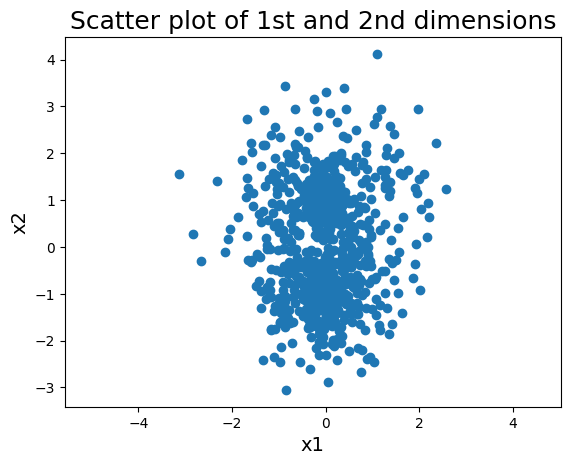

In [8]:
plt.scatter(X[:,0],X[:,1])
plt.title("Scatter plot of 1st and 2nd dimensions",size=18)
plt.xlabel("x1",size=14)
plt.ylabel("x2",size=14)
plt.axis("equal")
plt.show()

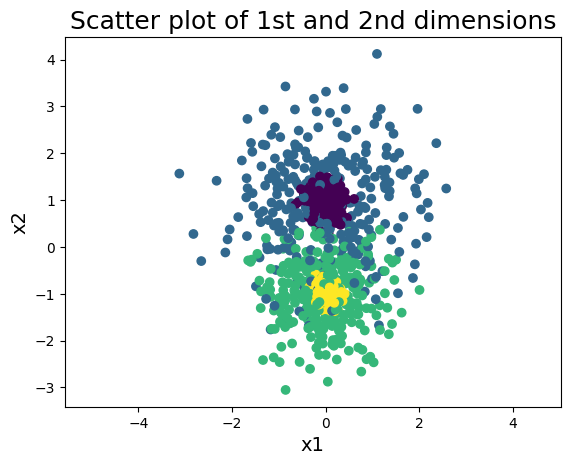

In [9]:
# Ground truth
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Scatter plot of 1st and 2nd dimensions",size=18)
plt.xlabel("x1",size=14)
plt.ylabel("x2",size=14)
plt.axis("equal")
plt.show()

## PCA

In [8]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA() # Initialize with n_components parameter to only find the top eigenvectors
z = pca.fit_transform(X)

PCA can produce an informative visualization where global structure and distances are preserved. We see two larger clusters and one smaller cluster; far-away clusters in the visualization are far-apart in the original space.

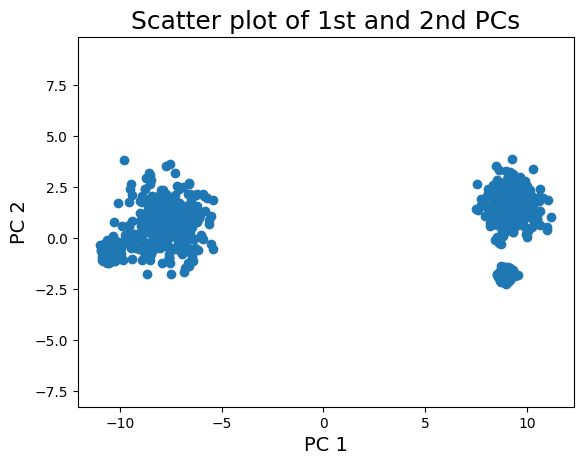

In [12]:
plt.scatter(z[:,0],z[:,1])
plt.title("Scatter plot of 1st and 2nd PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

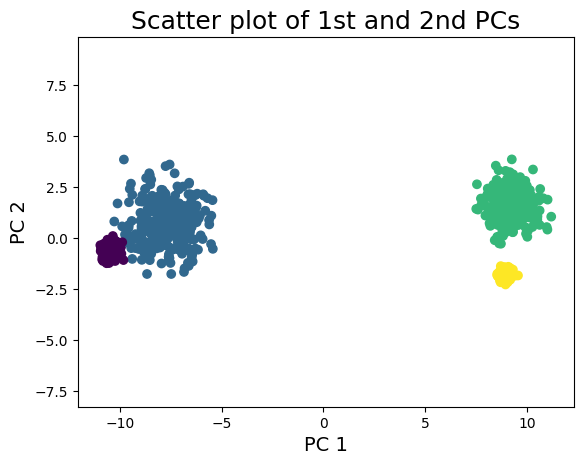

In [13]:
# With labels
plt.scatter(z[:,0],z[:,1],c=y)
plt.title("Scatter plot of 1st and 2nd PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

Deciding how many principal components to use

1. Scree/Elbow plot

You can use the elbow method to determine the number of principal components to use. The elbow method consists of plotting the explained variance as a function of the number of principal components. When an "elbow" appears in the plot, it indicates that that would be a good number of principal components to use in order to capture most of the variance in the data.

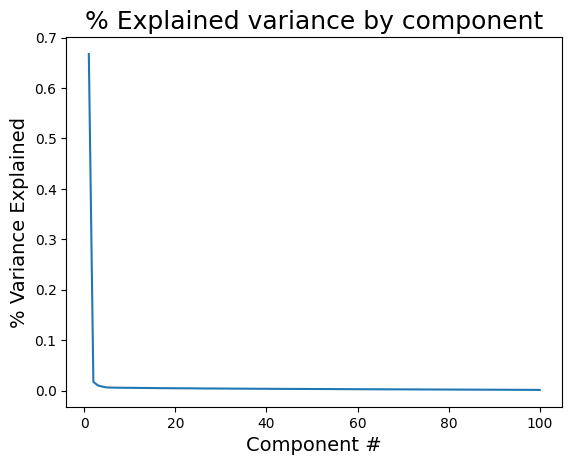

In [14]:
plt.plot(np.arange(1,101),pca.explained_variance_ratio_[0:100])
plt.title("% Explained variance by component",size=18)
plt.xlabel("Component #",size=14)
plt.ylabel("% Variance Explained",size=14)
plt.show()

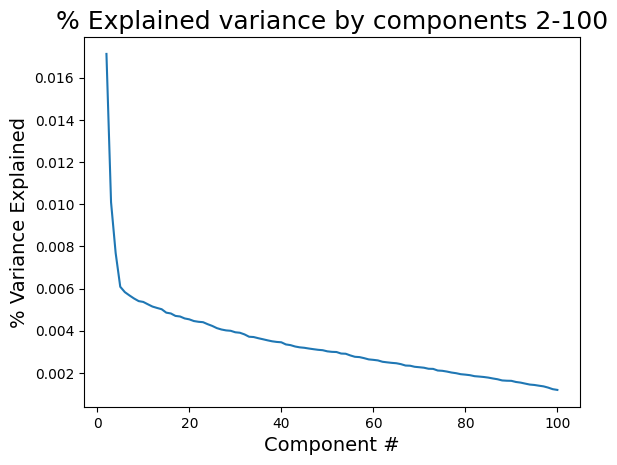

In [15]:
plt.plot(np.arange(2,101),pca.explained_variance_ratio_[1:100])
plt.title("% Explained variance by components 2-100",size=18)
plt.xlabel("Component #",size=14)
plt.ylabel("% Variance Explained",size=14)
plt.show()

In [16]:
np.sum(pca.explained_variance_ratio_[0:5])

0.7086416105001008

2. Cumulative variance explained threshold

You plot the cumulative sum of the explained variance ratio as a function of the number of principal components. This generates a plot that tells you how many principal components you need to explain a certain percentage of your data's variance. For example, in the chart below, you can see that you need around 40 components to explain 90% of the variance.

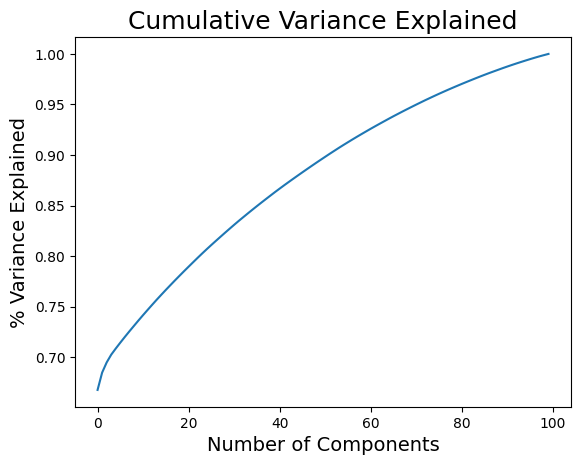

In [17]:
plt.plot(np.arange(0,100),np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Variance Explained",size=18)
plt.xlabel("Number of Components",size=14)
plt.ylabel("% Variance Explained",size=14)
plt.show()

In [18]:
np.where(np.cumsum(pca.explained_variance_ratio_) >=.85)[0][0]

36

3. Cross-validate

# MDS

MDS implementation in sklearn uses "stress" instead of "strain" - produces nonlinear embeddings, not equivalent to PCA. Implementation of MDS in R is equivalent to PCA though.

In [9]:
from sklearn.manifold import MDS

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


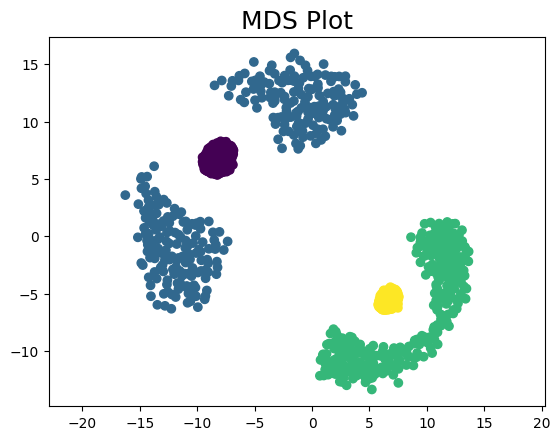

In [20]:
# MDS can be slow when n is large
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(X)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=y)
plt.title("MDS Plot",size=18)
plt.axis("equal")
plt.show()

breaking at iteration 50 with stress 0.11226947302263808
breaking at iteration 2 with stress 504.0991848348241
breaking at iteration 102 with stress 0.040460202953951474
breaking at iteration 45 with stress 0.11226956168301194
breaking at iteration 46 with stress 0.04046034095189959
breaking at iteration 45 with stress 0.11226974663460984
breaking at iteration 44 with stress 0.04046020560595273
breaking at iteration 43 with stress 0.11226947620319763
breaking at iteration 90 with stress 0.11226933909281372
breaking at iteration 45 with stress 0.040460354638752846


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


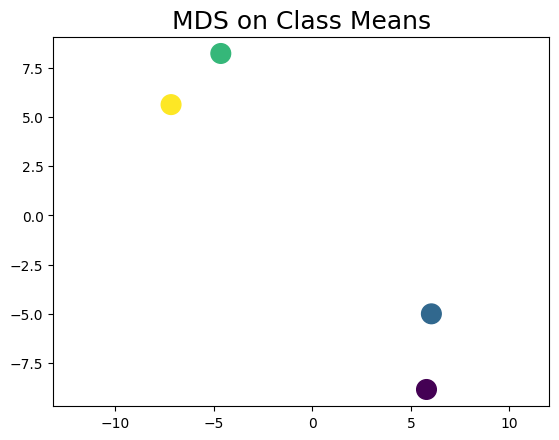

In [21]:
means = np.array([np.mean(X[np.where(y == i)],axis=0) for i in range(4)])
mds_means = MDS(2,verbose=1,eps=1e-8,n_init=10)
mds_means.fit(means)
plt.scatter(mds_means.embedding_[:,0],mds_means.embedding_[:,1],c=[0,1,2,3],s=200)
plt.title("MDS on Class Means",size=18)
plt.axis("equal")
plt.show()

# T-SNE

In [10]:
from sklearn.manifold import TSNE

Distances in the T-SNE graph don't necessarily mean anything! Remember that we have a mixture of Gaussians. For this particular dataset, T-SNE needs dimensionality reduction to reveal the clusters.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.688675
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.273155
[t-SNE] KL divergence after 1000 iterations: 1.915654


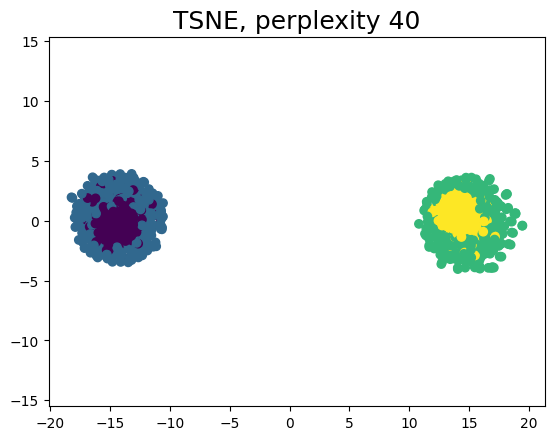

In [23]:
# Perplexity: Number of nearest neighbors to consider during matching
tsne = TSNE(n_components=2,verbose=1,perplexity=40)
z_tsne = tsne.fit_transform(X)
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
plt.title("TSNE, perplexity 40",size=18)
plt.axis("equal")
plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.456375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.460724
[t-SNE] KL divergence after 1000 iterations: 2.518117


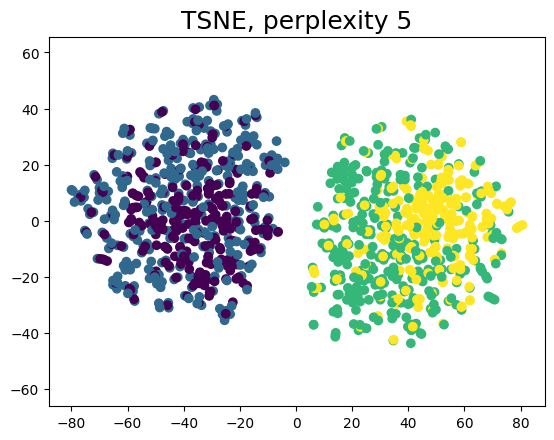

In [24]:
tsne = TSNE(n_components=2,verbose=1,perplexity=5)
z_tsne = tsne.fit_transform(X)
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
plt.title("TSNE, perplexity 5",size=18)
plt.axis("equal")
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.340281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.059856
[t-SNE] KL divergence after 1000 iterations: 1.224021


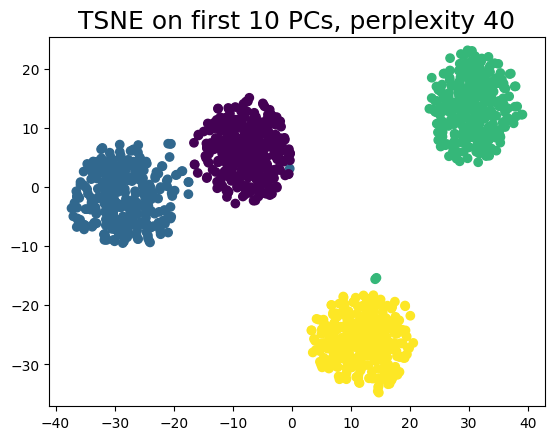

In [25]:
tsne = TSNE(n_components=2,verbose=1,perplexity=40)
z_tsne = tsne.fit_transform(z[:,0:10])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
plt.title("TSNE on first 10 PCs, perplexity 40",size=18)
plt.axis("equal")
plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.002s...
[t-SNE] Computed neighbors for 1200 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.205402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.310303
[t-SNE] KL divergence after 1000 iterations: 1.462196


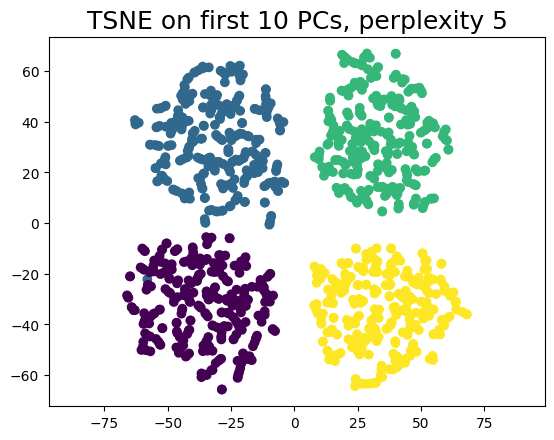

In [26]:
tsne = TSNE(n_components=2,verbose=1,perplexity=5)
z_tsne = tsne.fit_transform(z[:,0:10])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
plt.title("TSNE on first 10 PCs, perplexity 5",size=18)
plt.axis("equal")
plt.show()

T-SNE can be a powerful visualization tool for clustering! For the following dataset with 25 clusters, PCA does not show any distinct clusters, but T-SNE separates each one.

In [27]:
# Alternative dataset
mu2 = np.zeros((25,100))
for i in range(25):
    mu2[i,i] = 1
cov2 = [0.02*np.eye(100) for _ in range(25)]
X2,y2=sample_gmm(1000,mu2,cov2)

In [28]:
pca2 = PCA()
z2 = pca2.fit_transform(X2)

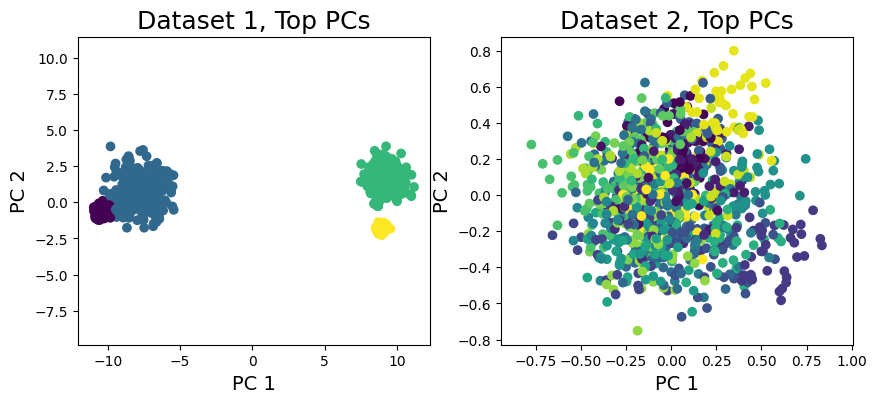

In [29]:
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
ax1.scatter(z[:,0],z[:,1],c=y)
ax1.set_title("Dataset 1, Top PCs",size=18)
ax1.set_xlabel("PC 1",size=14)
ax1.set_ylabel("PC 2",size=14)
ax1.axis("equal")

ax2.scatter(z2[:,0],z2[:,1],c=y2)
ax2.set_title("Dataset 2, Top PCs",size=18)
ax2.set_xlabel("PC 1",size=14)
ax2.set_ylabel("PC 2",size=14)
ax2.axis("equal")
plt.show()

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


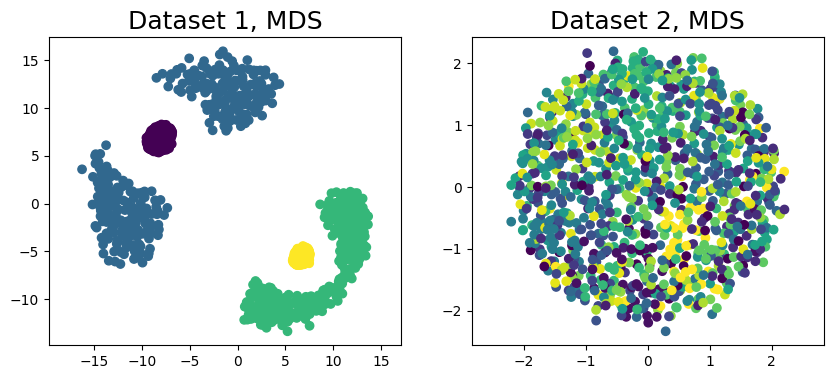

In [29]:
mds2 = MDS(n_components=2,verbose=1,eps=1e-5)
mds2.fit(X2)

fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
ax1.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=y)
ax1.set_title("Dataset 1, MDS",size=18)
ax1.axis("equal")

ax2.scatter(mds2.embedding_[:,0],mds2.embedding_[:,1],c=y2)
ax2.set_title("Dataset 2, MDS",size=18)
ax2.axis("equal")
plt.show()

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


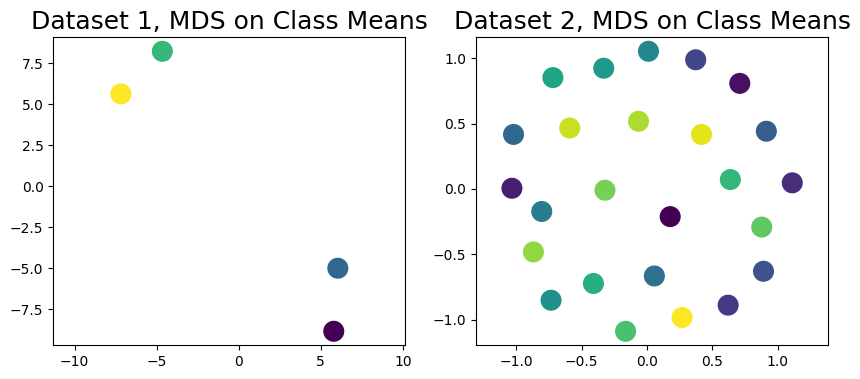

In [30]:
means2 = np.array([np.mean(X2[np.where(y2==i)[0]],0) for i in range(25)])
mds_means2 = MDS(n_components=2)
mds_means2.fit(means2)

fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
ax1.scatter(mds_means.embedding_[:,0],mds_means.embedding_[:,1],c=[i for i in range(4)],s=200)
ax1.set_title("Dataset 1, MDS on Class Means",size=18)
ax1.axis("equal")

ax2.scatter(mds_means2.embedding_[:,0],mds_means2.embedding_[:,1],c=[i for i in range(25)],s=200)
ax2.set_title("Dataset 2, MDS on Class Means",size=18)
ax2.axis("equal")
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.621258
[t-SNE] KL divergence after 50 iterations with early exaggeration: 66.928627
[t-SNE] KL divergence after 1000 iterations: 0.758223


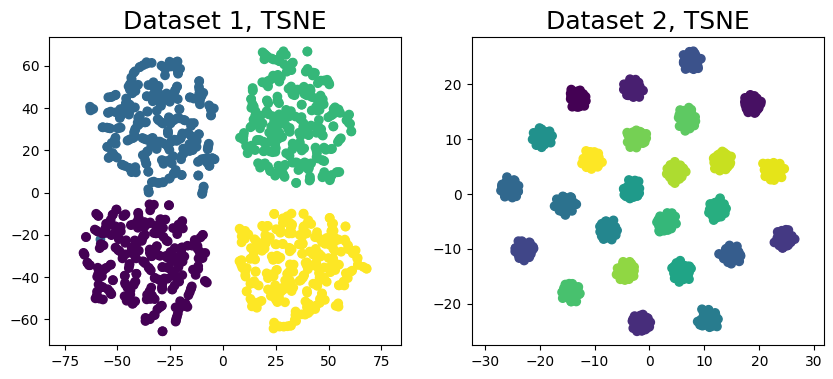

In [31]:
tsne2 = TSNE(n_components=2,verbose=1,perplexity=40)
z_tsne2 = tsne2.fit_transform(X2)

fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
ax1.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
ax1.set_title("Dataset 1, TSNE",size=18)
ax1.axis("equal")

ax2.scatter(z_tsne2[:,0],z_tsne2[:,1],c=y2)
ax2.set_title("Dataset 2, TSNE",size=18)
ax2.axis("equal")
plt.show()

# k-means

In [11]:
from sklearn.cluster import KMeans

Check number of initializations

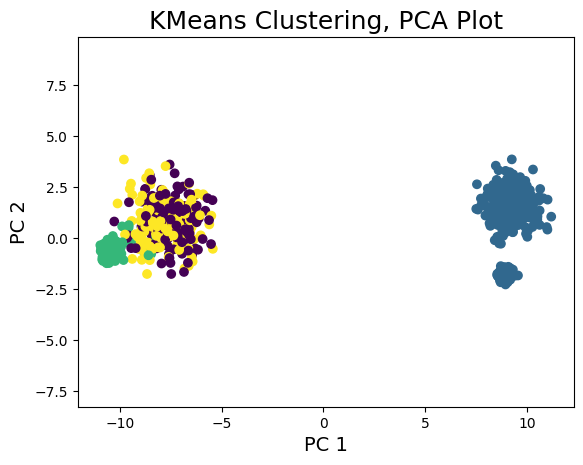

In [33]:
# n_init: Number of times to run k-means with different initializations
kmeans = KMeans(n_clusters=4,n_init=10)
y = kmeans.fit_predict(z)
plt.scatter(z[:,0],z[:,1],c=y)
plt.title("KMeans Clustering, PCA Plot",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

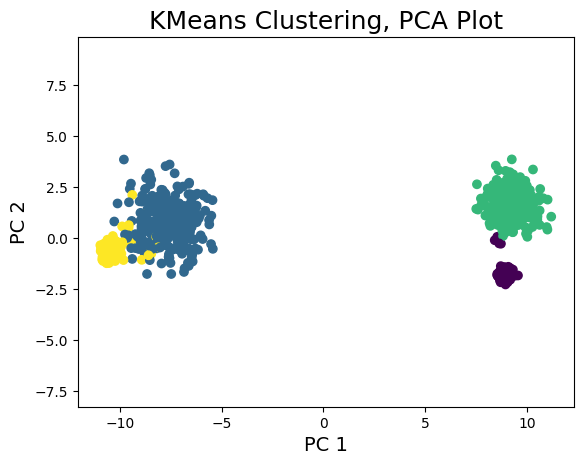

In [34]:
# More initializations
kmeans = KMeans(n_clusters=4,n_init=100)
y = kmeans.fit_predict(z)
plt.scatter(z[:,0],z[:,1],c=y)
plt.title("KMeans Clustering, PCA Plot",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

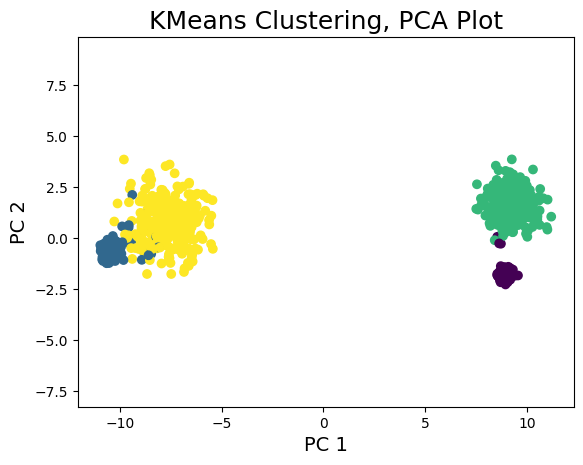

In [35]:
# Reduced dimension
kmeans = KMeans(n_clusters=4,n_init=10)
y = kmeans.fit_predict(z[:,0:10])
plt.scatter(z[:,0],z[:,1],c=y)
plt.title("KMeans Clustering, PCA Plot",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

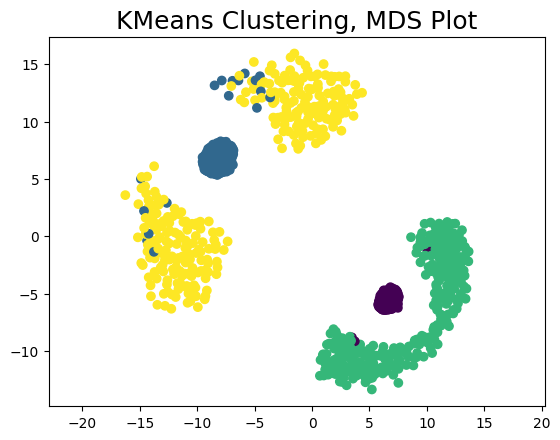

In [36]:
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=y)
plt.title("KMeans Clustering, MDS Plot",size=18)
plt.axis("equal")
plt.show()

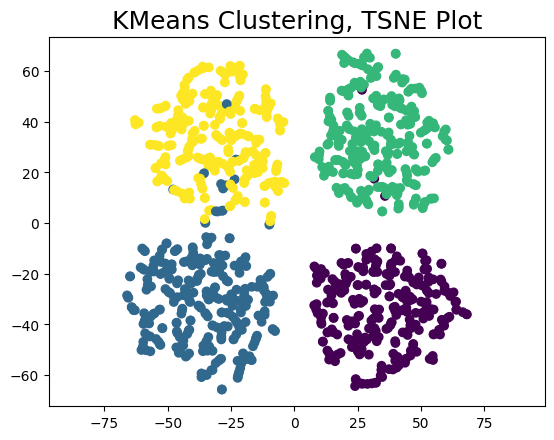

In [37]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)
plt.title("KMeans Clustering, TSNE Plot",size=18)
plt.axis("equal")
plt.show()

# Diagnostics: Sum of squares criterion, Silhouette

Sum of squares criterion is called "inertia" in sklearn. We can make an elbow plot:

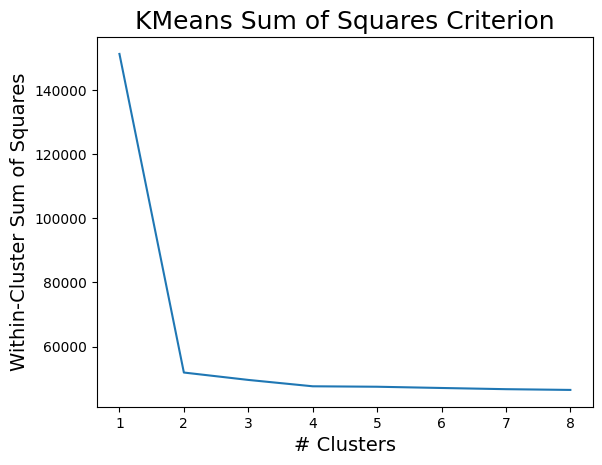

In [38]:
all_kmeans = [KMeans(n_clusters=i+1,n_init=100) for i in range(8)]
# i-th kmeans fits i+1 clusters
for i in range(8):
    all_kmeans[i].fit(X)

inertias = [all_kmeans[i].inertia_ for i in range(8)]
plt.plot(np.arange(1,9),inertias)
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()

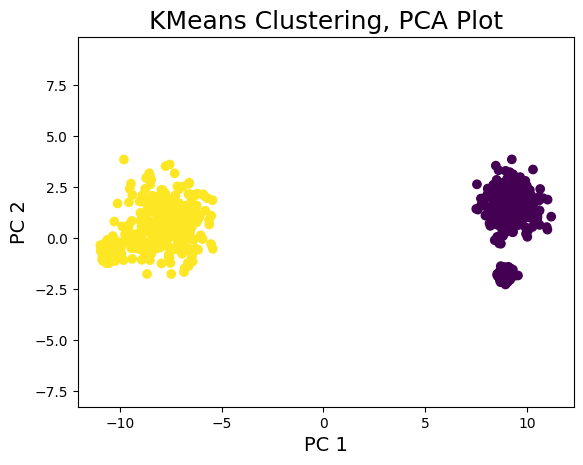

In [39]:
# Reduced dimension
kmeans = KMeans(n_clusters=2,n_init=10)
y = kmeans.fit_predict(z[:,0:10])
plt.scatter(z[:,0],z[:,1],c=y)
plt.title("KMeans Clustering, PCA Plot",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

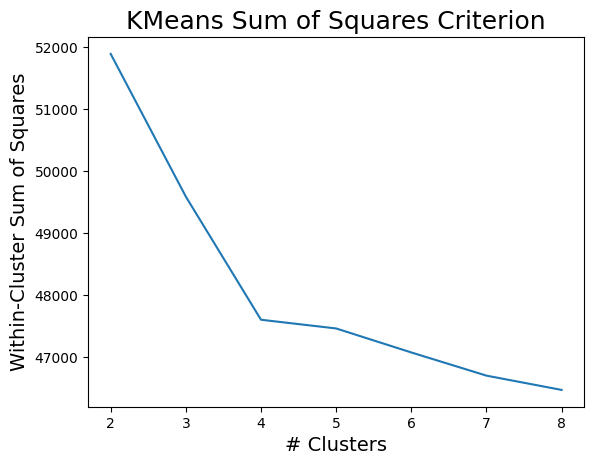

In [40]:
# Exclude having only 1 cluster
plt.plot(np.arange(2,9),inertias[1:])
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()

We can also plot silhouette scores. Silhouettes seem less reliable on high-dimensional data, can give negative scores even for clusters which look good visually.

In [12]:
from sklearn.metrics import silhouette_score, silhouette_samples

Yellowbrick is a package which supports Silhouette plots. But R has more developed functionality for this.

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.style import rcmod
from yellowbrick.style.colors import resolve_colors

# Ignore the warning that will pop up when we do rcmod.reset_orig()
import warnings
warnings.simplefilter(action='ignore', category=plt.cbook.MatplotlibDeprecationWarning)
# Yellowbrick changes the plotting settings, reset to default here

rcmod.reset_orig()

C:\Users\eddysanoli\AppData\Local\Temp\ipykernel_11524\3402859919.py:7: MatplotlibDeprecationWarning: MatplotlibDeprecationWarning was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.simplefilter(action='ignore', category=plt.cbook.MatplotlibDeprecationWarning)


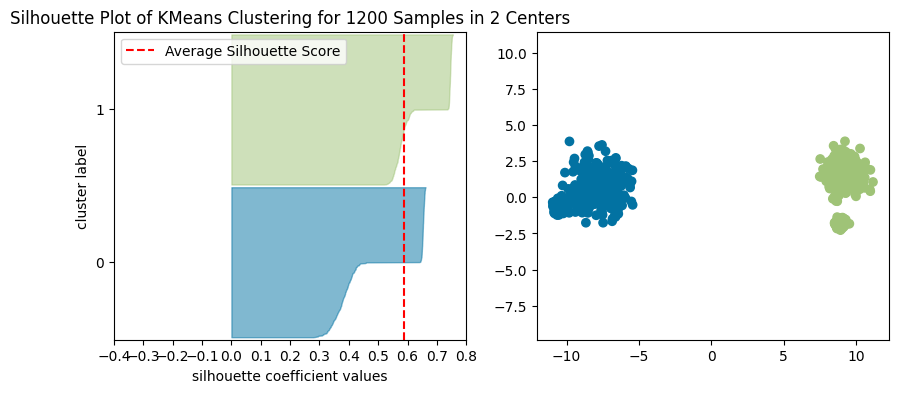

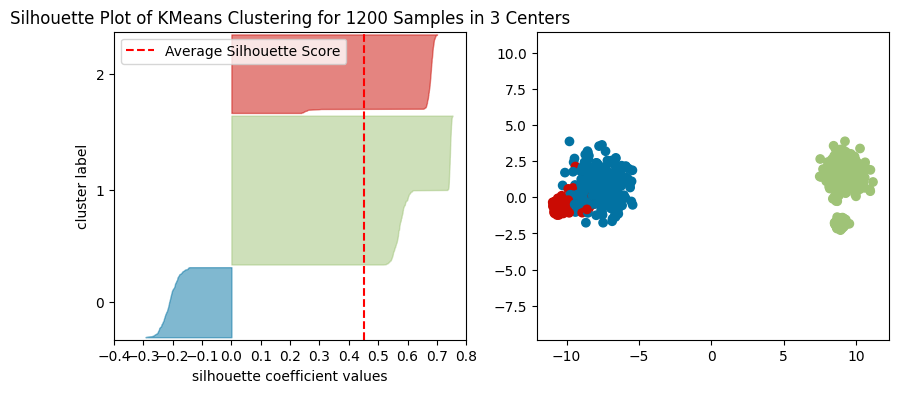

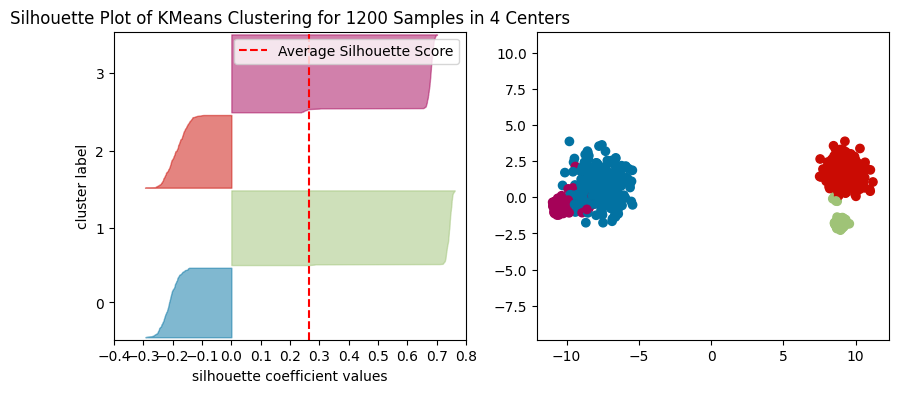

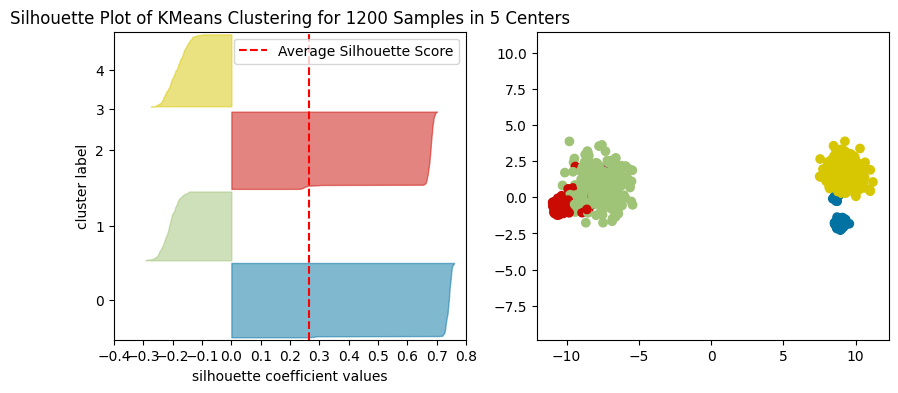

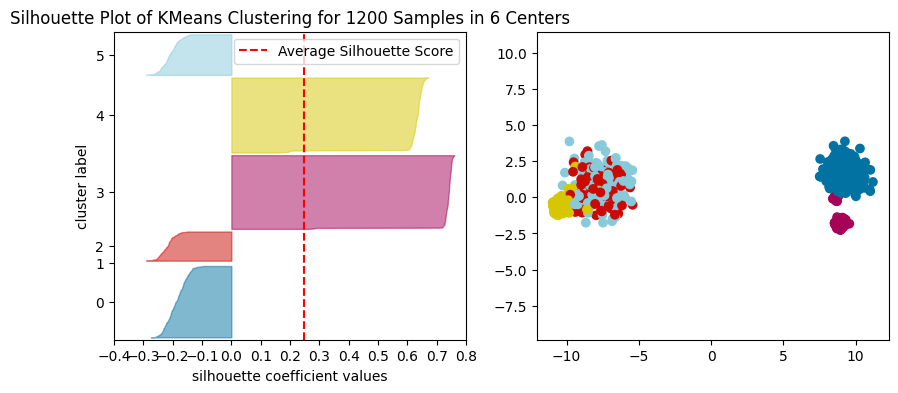

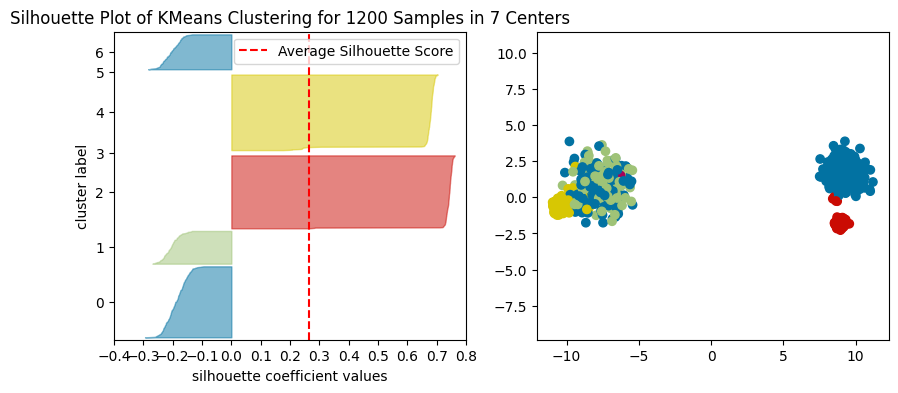

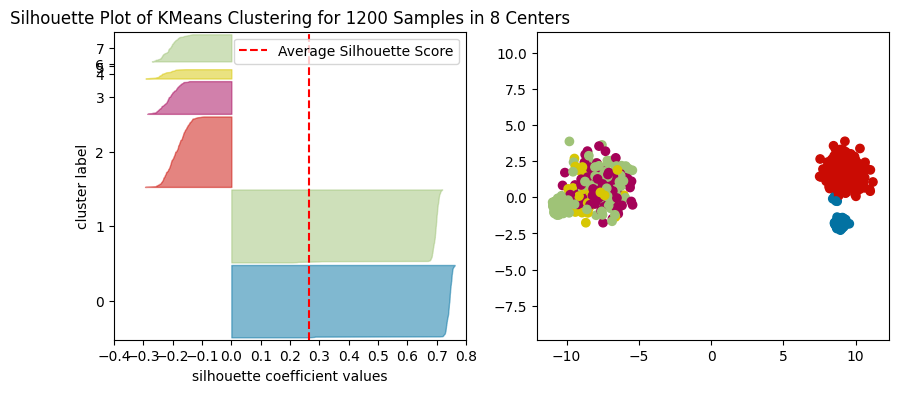

In [43]:
visualizers = [SilhouetteVisualizer(all_kmeans[i], colors='yellowbrick',is_fitted=True) for i in range(1,8)]
for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
    visualizer = SilhouetteVisualizer(all_kmeans[i+1], colors='yellowbrick',is_fitted=True,ax=ax1)
    visualizer.fit(X)
    
    colors = np.array(resolve_colors(i+2,"yellowbrick"))
    ax2.scatter(z[:,0],z[:,1],c=colors[all_kmeans[i+1].labels_])
    ax2.axis("equal")
    
    # If we want to set axes to be the same for all plots, need to do something like this
    # instead of visualizer.show(), which resets the axes
    visualizer.finalize()
    ax1.set_xlim((-.4,.8))
    plt.show()

Here we dont look for the elbow point, but for a maximum in the silhouette score (plot). As you can see, the maximum is at the very beginning, so we can conclude that the optimal number of clusters is "apparently" 2.

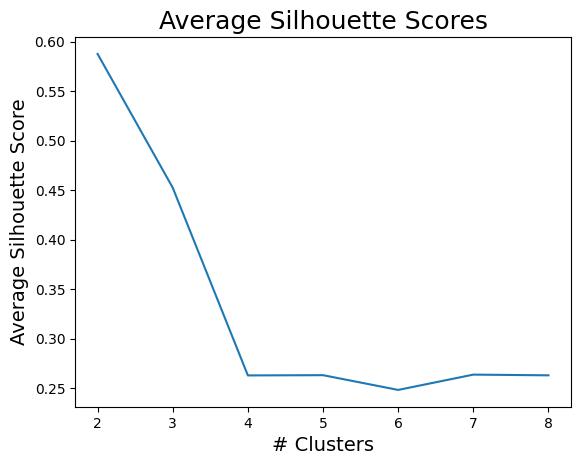

In [44]:
# Silhouette score undefined for 1 class. i-th entry of avg_silhouette score is score for i+2 clusters.
avg_silhouette_scores = [silhouette_score(X,all_kmeans[i].labels_) for i in range(1,8)]
plt.plot(np.arange(2,9),avg_silhouette_scores)
plt.title("Average Silhouette Scores",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Average Silhouette Score",size=14)
plt.show()

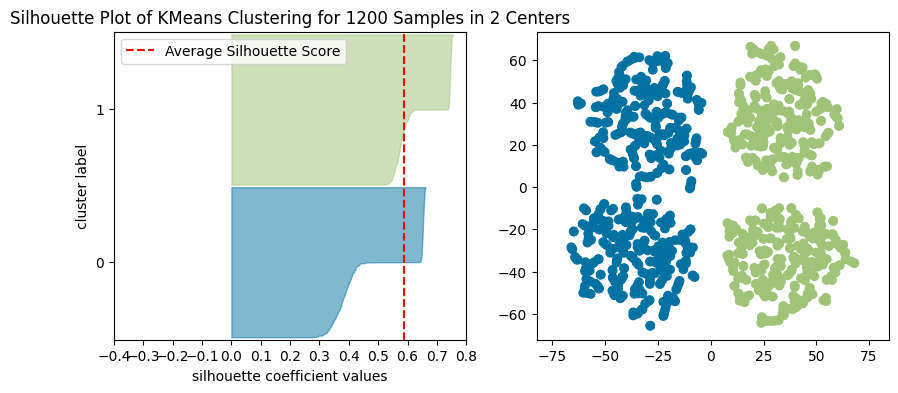

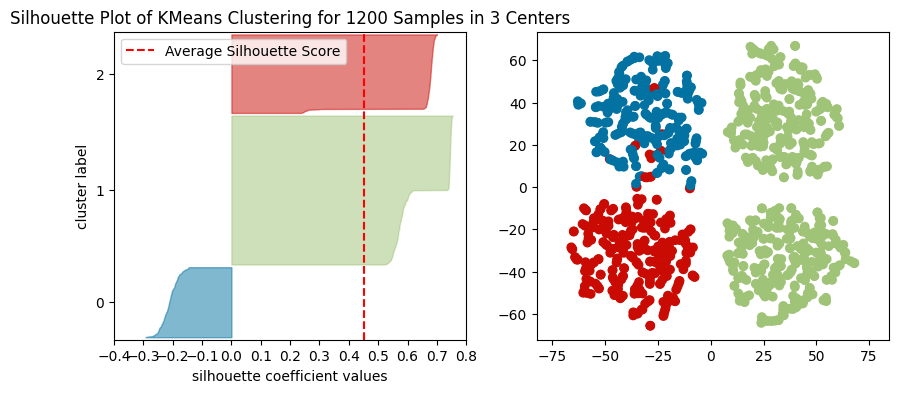

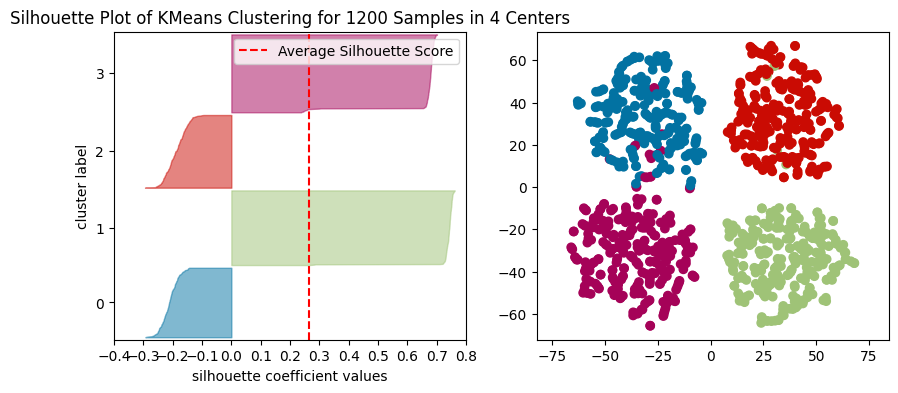

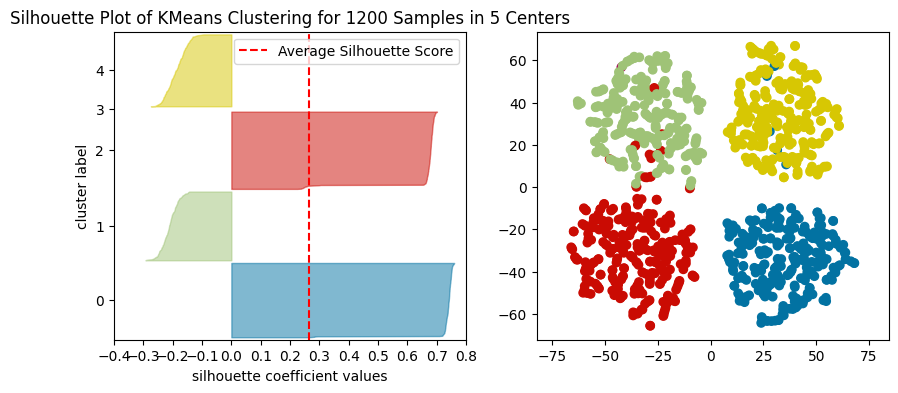

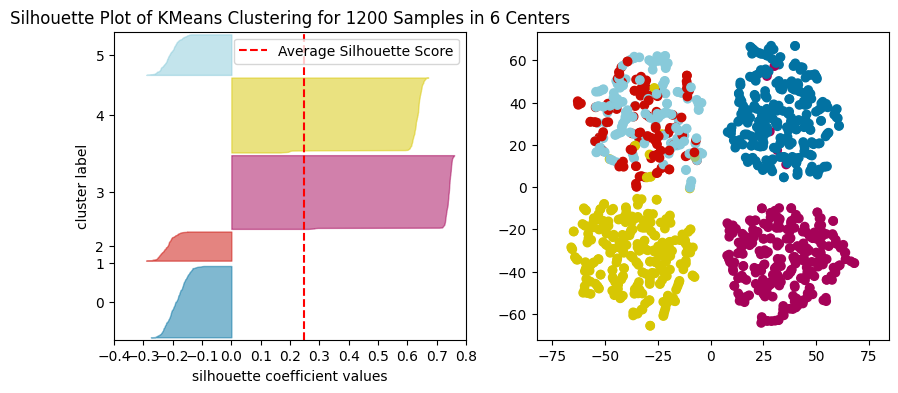

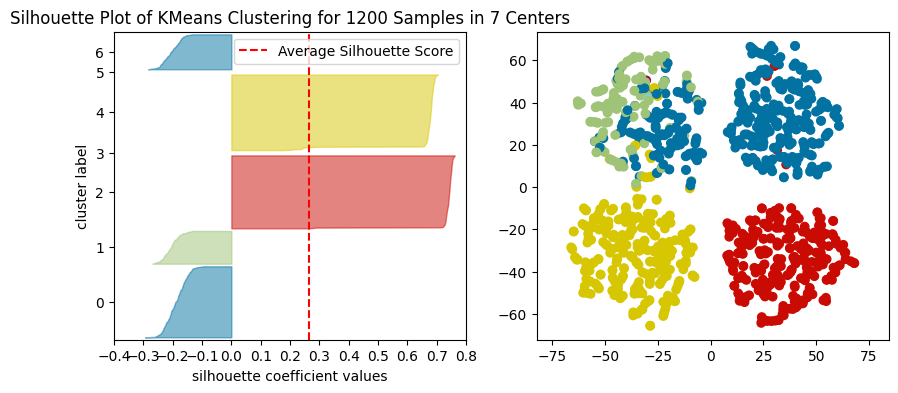

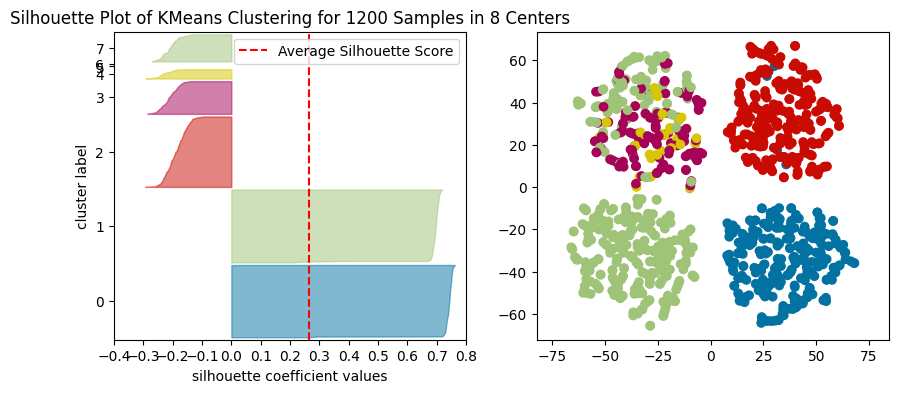

In [45]:
visualizers = [SilhouetteVisualizer(all_kmeans[i], colors='yellowbrick',is_fitted=True) for i in range(1,8)]
for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
    visualizer = SilhouetteVisualizer(all_kmeans[i+1], colors='yellowbrick',is_fitted=True,ax=ax1)
    visualizer.fit(X)
    
    colors = np.array(resolve_colors(i+2,"yellowbrick"))
    ax2.scatter(z_tsne[:,0],z_tsne[:,1],c=colors[all_kmeans[i+1].labels_])
    ax2.axis("equal")
    
    # If we want to set axes to be the same for all plots, need to do something like this
    # instead of visualizer.show(), which resets the axes
    visualizer.finalize()
    ax1.set_xlim((-.4,.8))
    plt.show()

# Wine Data Demo

RA Fisher's wine dataset, with chemical composition as features.

In [1]:
from sklearn.datasets import load_wine
features, target = load_wine(return_X_y=True)

In [2]:
features.shape

(178, 13)

For this dataset, it is customary to standardize the features

In [6]:
wine_std = (features-np.mean(features,0))/np.std(features,0)

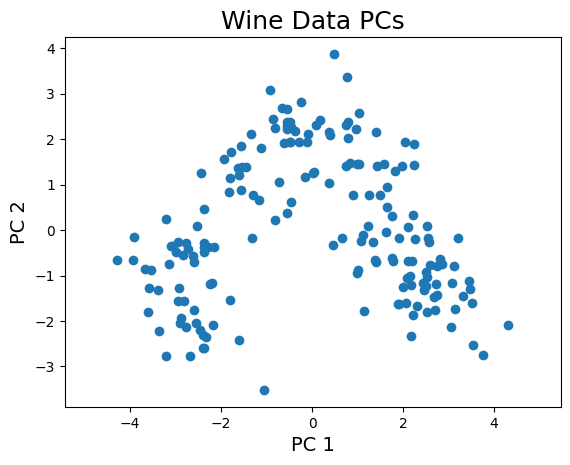

In [14]:
pca_wine = PCA(5).fit(wine_std)
pcs = pca_wine.transform(wine_std)
plt.scatter(pcs[:,0],pcs[:,1])
plt.title("Wine Data PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


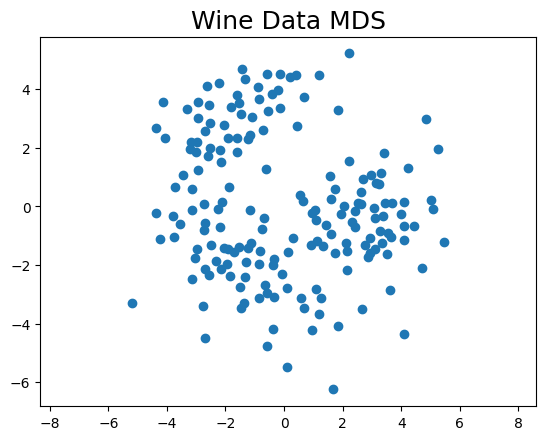

In [15]:
mds_wine = MDS(2).fit_transform(wine_std)
plt.scatter(mds_wine[:,0],mds_wine[:,1])
plt.title("Wine Data MDS",size=18)
plt.axis("equal")
plt.show()

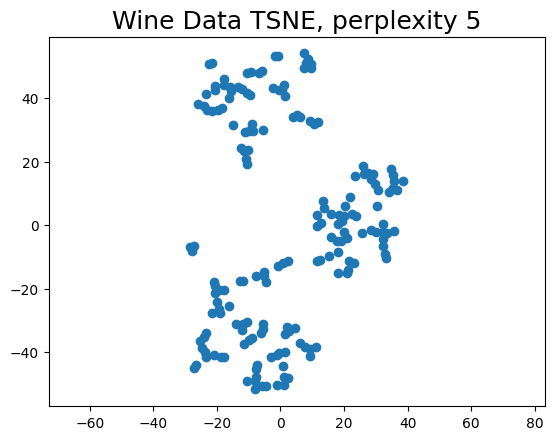

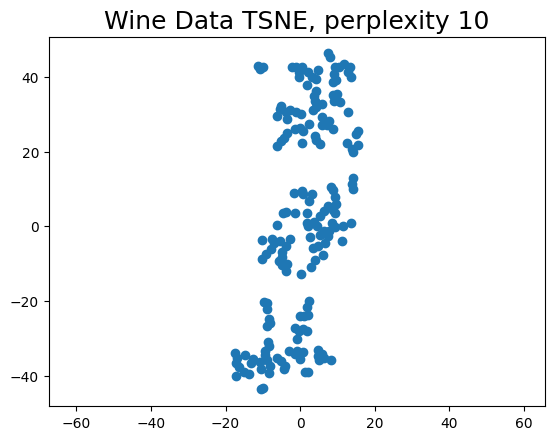

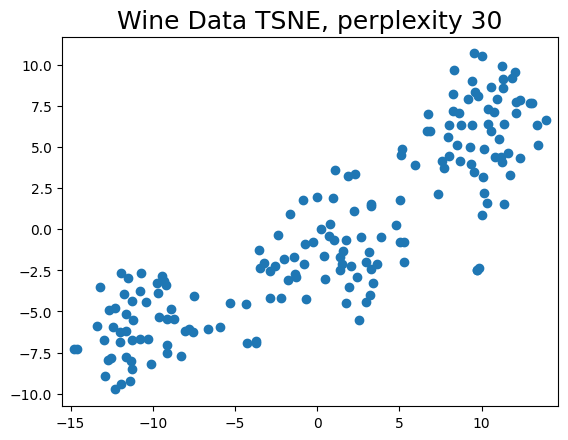

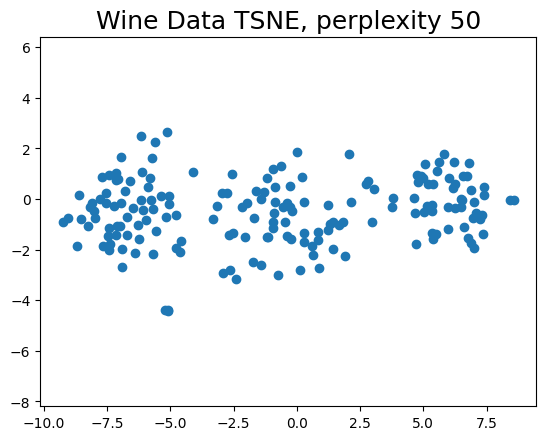

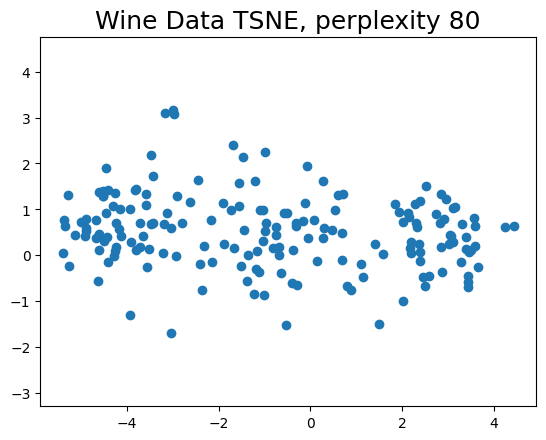

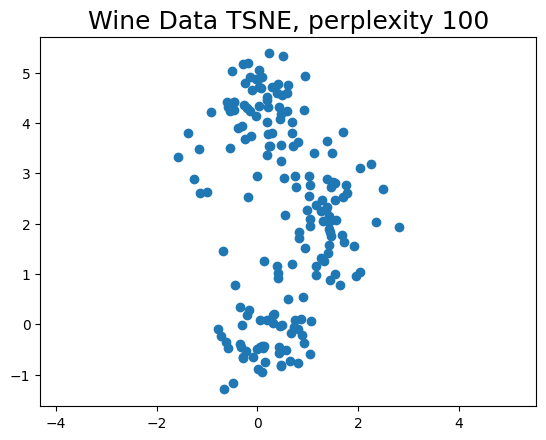

In [16]:
for perplexity in [5,10,30,50,80,100]:
    tsne_wine = TSNE(n_components=2,perplexity=perplexity).fit_transform(wine_std)
    plt.scatter(tsne_wine[:,0],tsne_wine[:,1])
    plt.title("Wine Data TSNE, perplexity "+str(perplexity),size=18)
    plt.axis("equal")
    plt.show()

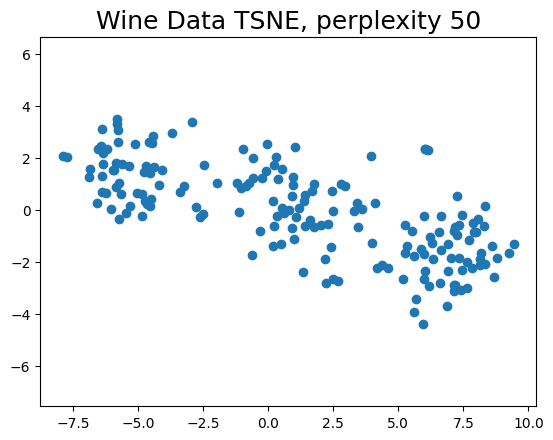

In [17]:
tsne_wine = TSNE(n_components=2,perplexity=50).fit_transform(wine_std)
plt.scatter(tsne_wine[:,0],tsne_wine[:,1])
plt.title("Wine Data TSNE, perplexity 50",size=18)
plt.axis("equal")
plt.show()

Elbow method+Silhouette score seem to converge on 3 clusters.

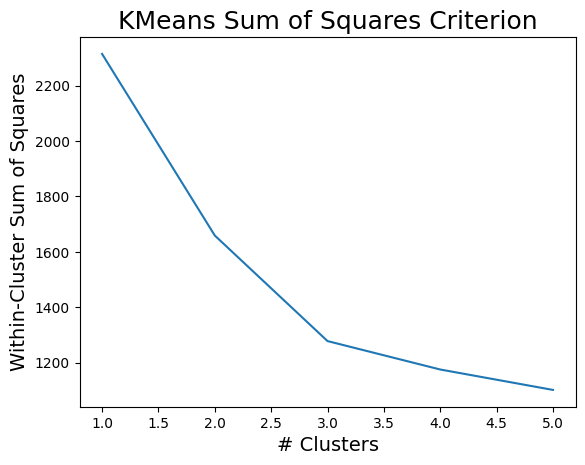

In [18]:
plt.plot(np.arange(1,6),[KMeans(i,n_init=50).fit(wine_std).inertia_ for i in range(1,6)])
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()

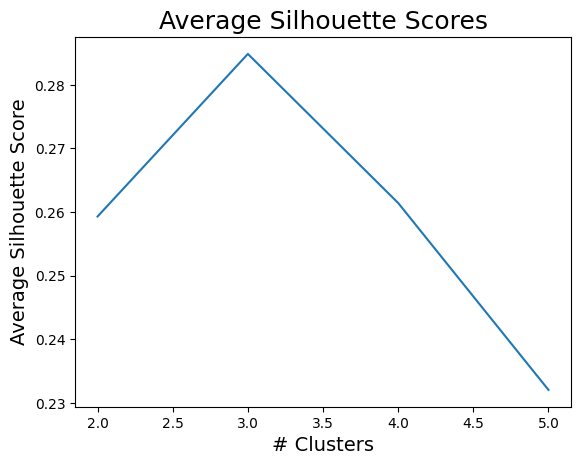

In [19]:
from sklearn.metrics import silhouette_score
plt.plot(np.arange(2,6),[silhouette_score(wine_std,KMeans(i,n_init=50).fit(wine_std).labels_) for i in range(2,6)])
plt.title("Average Silhouette Scores",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Average Silhouette Score",size=14)
plt.show()

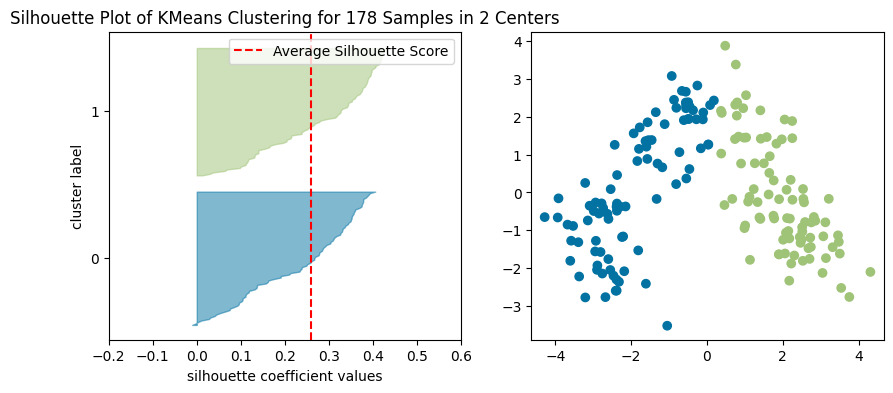

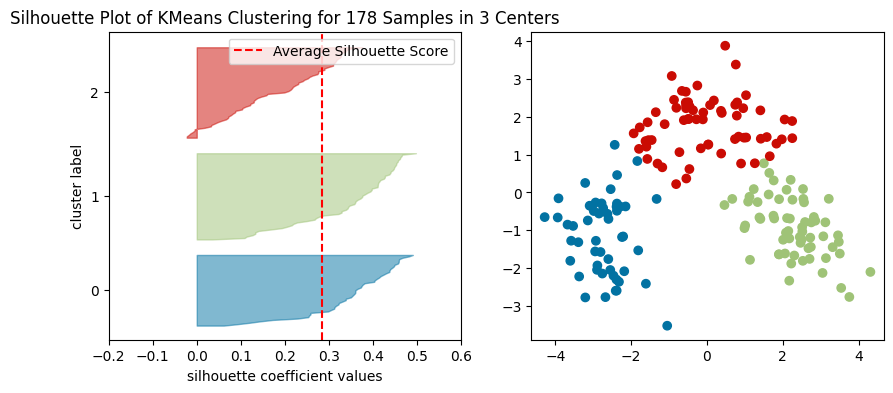

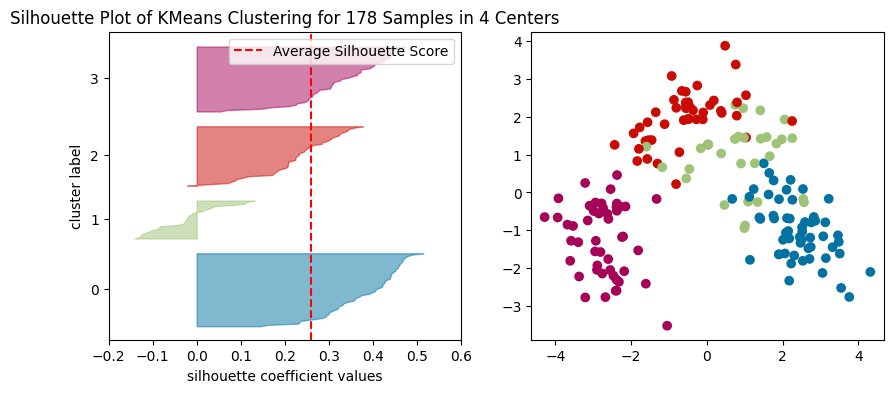

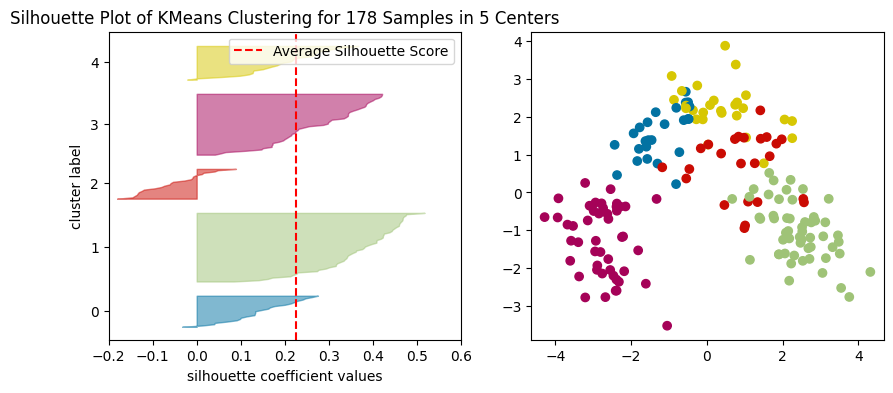

In [20]:
# Horizontal axes on the plots are not all the same range, be careful
for i in range(2,6):
    clustering = KMeans(i,n_init=50)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
    visualizer = SilhouetteVisualizer(clustering, colors='yellowbrick',is_fitted=False,ax=ax1)
    visualizer.fit(wine_std)
    
    
    colors = np.array(resolve_colors(i,"yellowbrick"))
    ax2.scatter(pcs[:,0],pcs[:,1],c=colors[clustering.labels_])
    ax2.axis("equal")
    
    
    # If we want to set axes to be the same for all plots, need to do something like this
    # instead of visualizer.show(), which resets the axes
    visualizer.finalize()
    ax1.set_xlim((-.2,.6))
    plt.show()

Looks nice!

In [21]:
clustering = KMeans(3,n_init=50)
clustering.fit(wine_std)
colors = np.array(resolve_colors(3,"yellowbrick"))

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


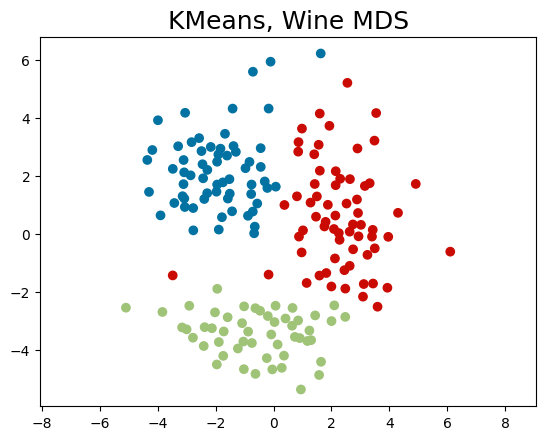

In [22]:
mds_wine = MDS(n_components=2).fit_transform(wine_std)
plt.scatter(mds_wine[:,0],mds_wine[:,1],c=colors[clustering.labels_])
plt.title("KMeans, Wine MDS",size=18)
plt.axis("equal")
plt.show()

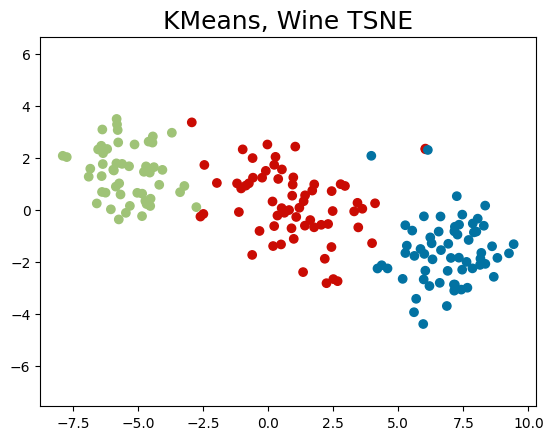

In [23]:
plt.scatter(tsne_wine[:,0],tsne_wine[:,1],c=colors[clustering.labels_])
plt.title("KMeans, Wine TSNE",size=18)
plt.axis("equal")
plt.show()

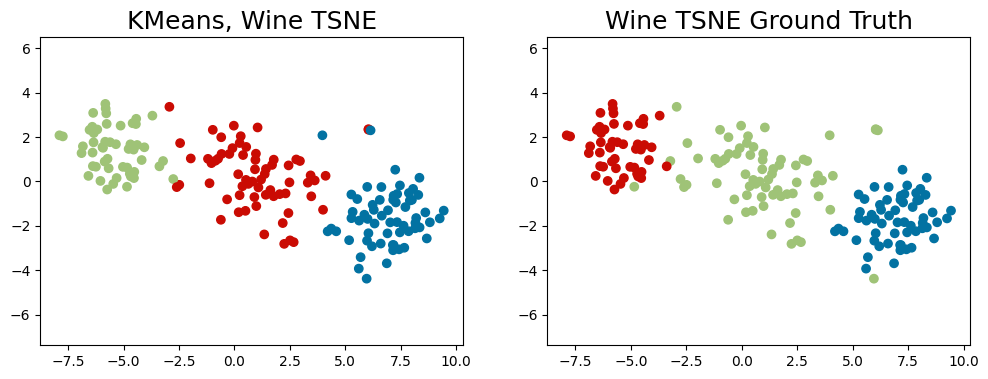

In [24]:
# Colors don't align since kmeans can order the clusters differently
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(tsne_wine[:,0],tsne_wine[:,1],c=colors[clustering.labels_])
ax1.set_title("KMeans, Wine TSNE",size=18)
ax2.scatter(tsne_wine[:,0],tsne_wine[:,1],c=colors[target])
ax2.set_title("Wine TSNE Ground Truth",size=18)
ax1.axis("equal")
ax2.axis("equal")
plt.show()

# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Separate into train and test data

In [26]:
np.random.seed(317)
perm = np.random.permutation(wine_std.shape[0])
n_train = int(4/5*wine_std.shape[0])
print(n_train)
X_train = wine_std[perm[:n_train]]
y_train = target[perm[:n_train]]
X_test = wine_std[perm[n_train:]]
y_test = target[perm[n_train:]]

142


## One-vs-rest, multinomial logistic regression
Prediction with k classes.

One-vs-rest: Train k binary classifiers. Each classifier i learns a rule class i vs not class i. Take classifier with maximum score as the class.

Multinomial: Softmax output on linear function of the data (generalization of sigmoid to multi-class).

Should often use some form of regularization

In [30]:
# Dont use L2 penalty
log_reg = LogisticRegression(penalty="none",multi_class="ovr").fit(X_train,y_train)

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [28]:
log_reg.score(X_train,y_train)

1.0

In [29]:
log_reg.score(X_test,y_test)

0.9444444444444444

C is inverse regularization strength. Small C -> more regularization.

Logistic regression is solved via iterative methods: different solvers exist, some support certain types of regularization or multi-class objective. Check documentation!

In [32]:
# Some solvers only support certain regularization/multi_class parameters
log_reg = LogisticRegression(penalty="l1",C=0.1,solver="liblinear",max_iter=5000,multi_class="ovr").fit(X_train,y_train)
log_reg.score(X_train,y_train)

0.9859154929577465

Cross Validation: divide data into k folds, train on k-1 folds and evaluate on remaining fold

In [33]:
log_reg = LogisticRegressionCV(cv=5,Cs=[0.01,0.1,1,10],max_iter=5000,penalty="l1",solver="liblinear",multi_class="ovr")
log_reg.fit(X_train,y_train)
log_reg.score(X_train,y_train)

1.0

In [34]:
log_reg.C_

array([10.,  1.,  1.])

In [35]:
log_reg.scores_

{0: array([[0.62068966, 0.96551724, 0.96551724, 0.96551724],
        [0.62068966, 0.86206897, 0.93103448, 1.        ],
        [0.64285714, 1.        , 1.        , 1.        ],
        [0.64285714, 0.96428571, 0.96428571, 0.96428571],
        [0.60714286, 1.        , 1.        , 1.        ]]),
 1: array([[0.65517241, 0.86206897, 1.        , 1.        ],
        [0.65517241, 0.89655172, 1.        , 1.        ],
        [0.64285714, 0.89285714, 1.        , 1.        ],
        [0.64285714, 0.92857143, 0.92857143, 0.92857143],
        [0.67857143, 0.92857143, 1.        , 1.        ]]),
 2: array([[0.72413793, 0.96551724, 1.        , 1.        ],
        [0.72413793, 0.96551724, 1.        , 1.        ],
        [0.71428571, 1.        , 1.        , 1.        ],
        [0.71428571, 0.89285714, 0.96428571, 0.96428571],
        [0.71428571, 0.96428571, 1.        , 1.        ]])}

In [36]:
log_reg.score(X_test,y_test)

1.0

Selecting features

In [38]:
log_reg.coef_

array([[ 3.01904739,  0.89481221,  2.25925389, -3.29183115,  0.        ,
         0.12315758,  1.80333714,  0.        , -0.08436216,  0.        ,
         0.        ,  2.3134176 ,  4.21220499],
       [-1.64870589, -0.3529101 , -1.02719162,  0.56958786, -0.01844499,
         0.        ,  0.25319991,  0.        ,  0.49946762, -1.74145521,
         1.32417857,  0.        , -2.46303997],
       [ 0.        ,  0.30034562,  0.30226877,  0.        ,  0.        ,
         0.        , -2.64727804,  0.        ,  0.        ,  2.12856281,
        -0.65561553, -0.36943446,  0.        ]])

One way: look at sum of absolute value per column

In [39]:
np.sum(np.abs(log_reg.coef_),axis=0)

array([4.66775328, 1.54806793, 3.58871428, 3.86141901, 0.01844499,
       0.12315758, 4.70381509, 0.        , 0.58382978, 3.87001802,
       1.9797941 , 2.68285206, 6.67524496])

Picking features with large coefficients

In [41]:
log_reg = LogisticRegressionCV(
    cv=5,
    Cs=[0.001,0.01,0.1,1,10],
    max_iter=5000,
    penalty="l1",
    solver="liblinear",
    multi_class="ovr"
)
log_reg.fit(X_train[:,np.array([0,12])],y_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=5000,
                     multi_class='ovr', penalty='l1', solver='liblinear')

In [42]:
log_reg.score(X_train[:,np.array([0,12])],y_train)

0.8028169014084507

In [43]:
log_reg.score(X_test[:,np.array([0,12])],y_test)

0.75

In [44]:
log_reg = LogisticRegressionCV(cv=5,Cs=[0.001,0.01,0.1,1,10],max_iter=5000,penalty="l1",solver="liblinear",multi_class="ovr")
log_reg.fit(X_train[:,np.array([4,5])],y_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=5000,
                     multi_class='ovr', penalty='l1', solver='liblinear')

In [45]:
log_reg.score(X_train[:,np.array([4,5])],y_train)

0.7394366197183099

In [46]:
log_reg.score(X_test[:,np.array([4,5])],y_test)

0.6388888888888888